In [1]:
# import Pkg
# Pkg.add("DifferentialEquations")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("ModelingToolkit")
# Pkg.add("LSODA")
# Pkg.add("BenchmarkTools")
# Pkg.add("DataFrames")
# Pkg.add("CSV")

In [2]:
using DifferentialEquations
using Plots
using DataFrames, CSV
using BenchmarkTools

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1342


In [ ]:
# using Sundials, LSODA
# using ModelingToolkit

In [3]:
dirname_model = "../src/model_ctypes/ina_pipette/"

filename_legend_constants = Base.Filesystem.joinpath(dirname_model, "legend_constants.csv")
filename_legend_states = Base.Filesystem.joinpath(dirname_model, "legend_test.csv")
filename_protocol = Base.Filesystem.joinpath("../data/protocols/protocol_sparse.csv");

In [4]:
legend_states = DataFrame(CSV.File(filename_legend_states))
legend_constants = DataFrame(CSV.File(filename_legend_constants))
protocol = DataFrame(CSV.File(filename_protocol))

,t,v
,Float64,Float64
1,0.0,-80.0
2,0.00395,-70.0
3,0.05395,-80.0
4,0.25395,-70.0
5,0.30395,-80.0
6,0.35395,-75.0
7,0.45395,-80.0
8,0.50395,-70.0
9,0.55395,-80.0


In [5]:
function find_step(t)
    index = findfirst(x -> x >= t, protocol.t)
    v = protocol.v[index]
end

find_step (generic function with 1 method)

In [6]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    v_c = p.v_c  # find_step(t)
    
    tau_m = 1 / (p.a0_m * exp(v_m / p.s_m) + p.b0_m * exp(-v_m / p.delta_m))
    tau_h = 1 / (p.a0_h * exp(-v_m / p.s_h) + p.b0_h * exp(v_m / p.delta_h))
    tau_j = p.tau_j_const + 1 / (p.a0_j * exp(-v_m / p.s_j) + p.b0_j * exp(v_m / p.delta_j))
    
    m_inf = 1 / (1 + exp(-(p.v_half_m + v_m) / p.k_m))
    h_inf = 1 / (1 + exp((p.v_half_h + v_m) / p.k_h))
    
    v_cp = v_c + (v_c - v_comp) * (1 / (1 - p.alpha) - 1)

    I_leak = p.g_leak * v_m
    I_Na = p.g_max * h * m^3 * j * (v_m - p.v_rev)
    I_c = 1e9 * p.c_m * ((v_p + p.v_off - v_m) / (p.R * p.c_m) - 1e-9 * (I_leak + I_Na) / p.c_m)
    I_p = 1e9 * p.c_p * (v_cp - v_p) / (p.c_p * p.R_f)
    I_comp = 1e9 * p.x_c_comp * p.c_m * (v_c - v_comp) / (p.x_c_comp * p.c_m * p.x_r_comp * p.R * (1 - p.alpha))
    I_in = I_leak + I_Na + I_c  + I_p - I_comp
    
    a = (tau_m=tau_m, tau_h=tau_h, tau_j=tau_j,
         m_inf=m_inf, h_inf=h_inf,
         v_cp=v_cp, I_leak=I_leak, I_Na=I_Na, I_c=I_c, I_p=I_p, I_comp=I_comp, I_in=I_in,
         v_c=v_c)
    
    return a
end

compute_algebraic (generic function with 1 method)

In [7]:
function compute_rates!(du, u, p, t)
        
    v_comp, v_p, v_m, m, h, j, I_out = u
    a = compute_algebraic(du, u, p, t)
    
    du[1] = (a.v_c - v_comp) / (p.x_c_comp * p.c_m * p.x_r_comp * p.R * (1 - p.alpha))  # v_comp
    du[2] = (a.v_cp - v_p) / (p.c_p * p.R_f)  # v_p
    du[3] = (v_p + p.v_off - v_m) / (p.R * p.c_m) - (1e-9) * (a.I_leak + a.I_Na) / p.c_m  # v_m
        
    du[4] = (a.m_inf - m) / a.tau_m  # m
    du[5] = (a.h_inf - h) / a.tau_h  # h
    du[6] = (a.h_inf - j) / a.tau_j  # j
        
    du[7] = (a.I_in - I_out) / p.tau_z  # I_out
    
    nothing
end

compute_rates! (generic function with 1 method)

In [8]:
function update_p(v_c)
    legend_constants[!, :value][end] = v_c
    p = collect(zip(Symbol.(legend_constants[!, :name]),
                legend_constants[!, :value]))
    p = NamedTuple(p)
end

update_p (generic function with 1 method)

In [9]:
tspan = (0, 0)
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
du = zero(u₀)
p = update_p(-80)

pl = plot()

for row in eachrow(protocol[2:end, :])
    tspan = (tspan[2], row.t)
    prob = ODEProblem(compute_rates!, u₀, tspan, p)
    sol = solve(prob, alg=Rodas5(), reltol=1e-8, abstol=1e-8)
    plot!(sol.t, sol[end, :], label=nothing)
    p = update_p(row.v)
    u₀ = deepcopy(sol.u[end])
end

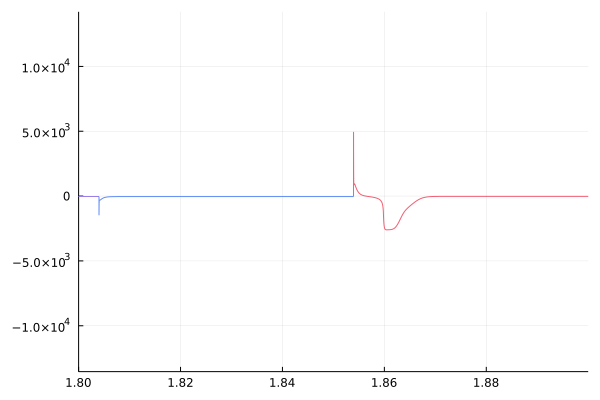

In [10]:
plot!(xlims=(1.8, 1.9))
pl

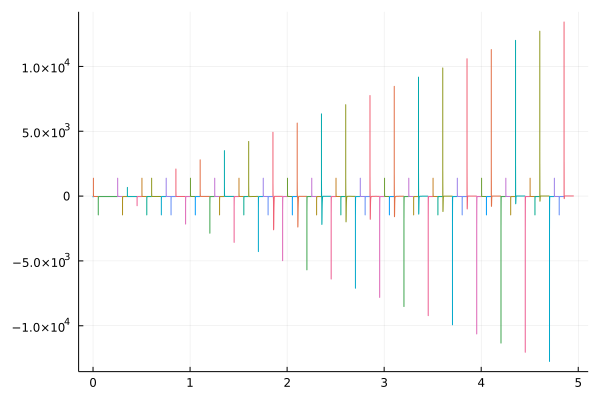

In [13]:
plot!(xlims=nothing)
pl

In [11]:
# I_comp = map(sol) do x
#         a = compute_algebraic(0, x, p, 0)
#         a.I_p
# end